<a href="https://colab.research.google.com/github/eleubner02/01-Stat-Arb-Pairs-Trading/blob/feat%2Fzscore-signal-generation/notebooks/pairs_trading_analysis_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install yfinance

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib as plt

In [3]:
stock1 = 'PEP'
stock2 = 'KO'

data = yf.download([stock1, stock2], start='2020-01-01', end='2025-01-01')

/tmp/ipython-input-284055099.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download([stock1, stock2], start='2020-01-01', end='2025-01-01')
[*********************100%***********************]  2 of 2 completed


<Axes: xlabel='Date'>

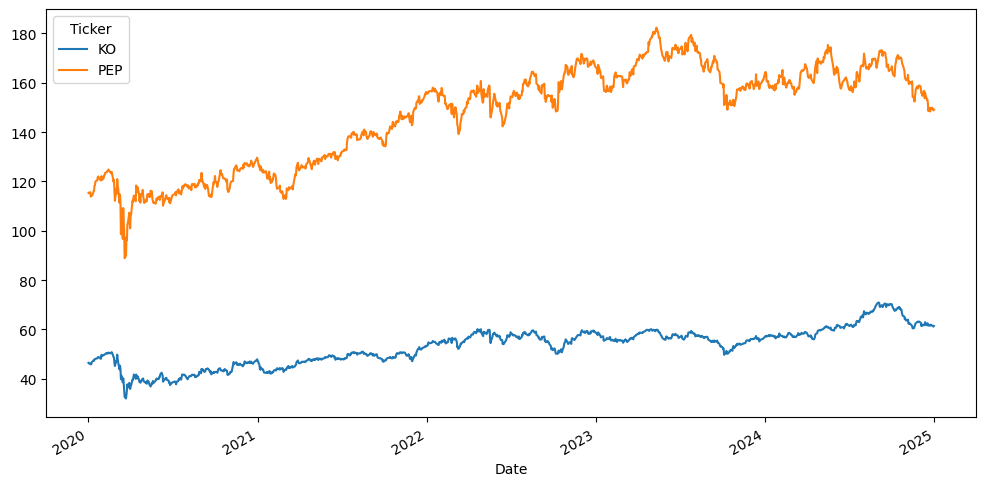

In [4]:
data['Close'].plot(figsize=(12,6))

In [5]:
import statsmodels.api as sm

Next, I will perform the Engle-Granger test to check for cointegration. This is critical because a stationary spread is required for a mean-reverting strategy to be viable.

In [6]:
test_statistic, p_value, critical_values = sm.tsa.stattools.coint(data['Close'][stock1], data['Close'][stock2], trend='c', method='aeg', maxlag=None, autolag='aic', return_results=None)

print(f"Cointegration Test Results:")
print(f"  Test Statistic: {test_statistic}")
print(f"  P-value: {p_value}")
print(f"  Critical Values (1%, 5%, 10%): {critical_values}")

if p_value < 0.05:
    print("\nBased on the p-value, we can reject the null hypothesis and conclude that ", stock1, " and ", stock2, " are likely cointegrated.")
else:
    print("\nBased on the p-value, we cannot reject the null hypothesis and there is not enough evidence to conclude that ", stock1, " and ", stock2, " are cointegrated.")

Cointegration Test Results:
  Test Statistic: -2.1135928955953
  P-value: 0.4692639617825864
  Critical Values (1%, 5%, 10%): [-3.90517395 -3.34099518 -3.04782579]

Based on the p-value, we cannot reject the null hypothesis and there is not enough evidence to conclude that  PEP  and  KO  are cointegrated.


### Cointegration Test Analysis

The Engle-Granger test resulted in a p-value of 0.469. The null hypothesis for this test is that the two series are not cointegrated. Since our p-value (0.469) is significantly greater than the standard significance level of 0.05, we fail to reject the null hypothesis.

**Conclusion:** There is no statistical evidence in this dataset to suggest that PEP and KO are cointegrated. Therefore, they are not a suitable pair for this pairs trading strategy.

# Z-Score

While the cointegration test was our permission to trade, the z-score serves as our signal to trade. The z-score is a normalized measure, which coupled with thresholds, tells us when we are far enough from the mean spread to execute our strategy.


Dates when z-score crosses the upper threshold:
DatetimeIndex(['2020-09-02', '2020-10-01', '2020-10-13', '2020-10-14',
               '2020-12-01', '2021-07-14', '2021-07-15', '2021-07-16',
               '2021-07-19', '2021-07-20', '2021-07-23', '2021-07-26',
               '2021-07-27', '2021-08-19', '2021-08-20', '2021-10-14',
               '2021-10-19', '2021-10-20', '2021-10-26', '2021-11-02',
               '2021-11-03', '2021-11-04', '2021-11-05', '2021-11-19',
               '2021-11-22', '2021-11-23', '2021-11-29', '2021-12-03',
               '2021-12-06', '2021-12-07', '2021-12-08', '2021-12-09',
               '2021-12-10', '2021-12-13', '2021-12-14', '2021-12-15',
               '2021-12-16', '2021-12-29', '2021-12-31', '2022-08-01',
               '2022-08-03', '2022-08-04', '2022-08-12', '2022-08-15',
               '2022-08-16', '2022-08-17', '2022-08-18', '2022-08-19',
               '2022-10-13', '2022-10-17', '2022-10-18', '2022-10-24',
               '2022-10-25',

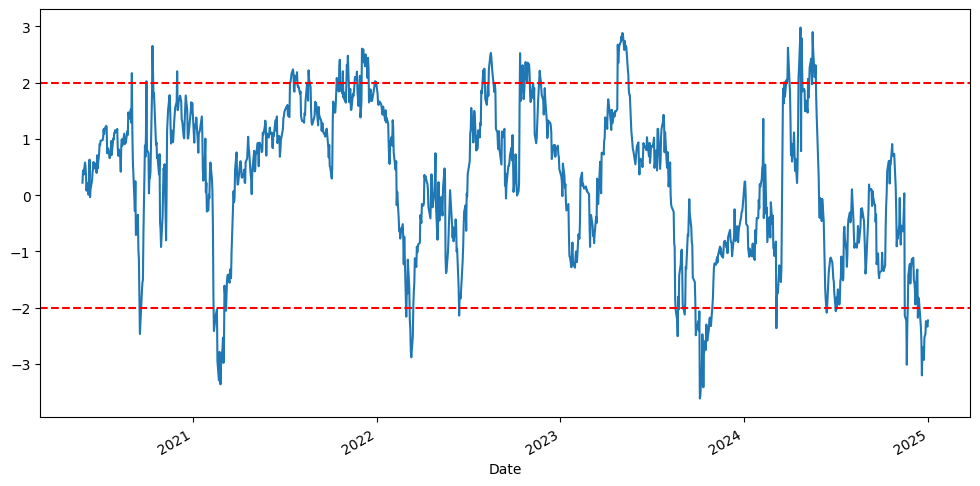

In [10]:
spread = data['Close'][stock1] - data['Close'][stock2]

# z-score function. .shift(1) is crucial because it prevents lookahead bias by only focusing on data before a given date
def zscore(x, window):
    r = x.rolling(window=window)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (x-m)/s
    return z

z_score = zscore(spread, 100)

upper_threshold = 2.0
lower_threshold = -2.0

ax = z_score.plot(figsize=(12,6))
ax.axhline(upper_threshold, color='r', linestyle='--')
ax.axhline(lower_threshold, color='r', linestyle='--')

# Identify dates where the z-score crosses the thresholds
upper_crossings = z_score[z_score > upper_threshold].index
lower_crossings = z_score[z_score < lower_threshold].index

print("\nDates when z-score crosses the upper threshold:")
print(upper_crossings)

print("\nDates when z-score crosses the lower threshold:")
print(lower_crossings)

The above z-score visualization is powerful because it confirms the mean-reverting property of the spread.